In [ ]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np

from dataset import get_dataset
from logger import Logger
from core.models import get_model
from core import solver_dict
from init import get_cfg, setup_seed, dev_get_cfg

# preparer configuration
cfg  =dev_get_cfg()

device = "cuda"

# set random seed
setup_seed(cfg["rand_seed"])

# prepare dataset
DatasetClass = get_dataset(cfg)
datasets_dict = dict()
for mode in cfg["modes"]:
    datasets_dict[mode] = DatasetClass(cfg, mode=mode)

# prepare models
ModelClass = get_model(cfg["model"]["model_name"])
model = ModelClass(cfg)

# prepare logger
logger = Logger(cfg)

# register dataset, models, logger to the solver
solver = solver_dict[cfg["runner"].lower()](cfg, model, datasets_dict, logger)

In [ ]:
ckpt_path = "/home/ziran/se3/EFEM/weights/mugs.pt"
ckpt = torch.load(ckpt_path)
model.network.load_state_dict(ckpt['model_state_dict'])

In [ ]:
# codebook_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/codebook.npz"
codebook_path = "/home/ziran/se3/EFEM/cache/mugs.npz"

with np.load(codebook_path) as data:
    # 将 npz 文件内容转换为字典
    codebook = {key: data[key] for key in data}

del codebook['id']
for k, v in codebook.items():
    if isinstance(v, np.ndarray):
        newv = torch.from_numpy(v)
        codebook[k] = newv
    print(k, v.shape)

In [ ]:
codebook.keys()

In [ ]:
codebook['scale'].min()

In [ ]:
bs = 1
pred_so3_feat = codebook['z_so3'][:bs]
pred_inv_feat = codebook['z_inv'][:bs]
pred_scale = codebook['scale'][:bs]
pred_scale = torch.ones_like(pred_scale) + 0.2
pred_center = codebook['center'][:bs]
pred_center = torch.zeros_like(pred_center)
# 上面两个注释掉的, 如果用默认0和1的center和scale, 会导致decode不太行, 还是用codebook里的比较好
# 于是那就应该把这四个variable一块diffusion


In [ ]:
def show_indi(AE_model, pred_so3_feat, pred_inv_feat, pred_scale, pred_center, N = 50, level=0.01, angle_x=30, angle_y=60):
    pred_so3_feat = pred_so3_feat.to(device)
    pred_inv_feat = pred_inv_feat.to(device)
    pred_scale = pred_scale.to(device)
    pred_center = pred_center.to(device)
    
    space_dim = [N, N, N]  # 示例为一个50x50x50的网格
    di = 1
    # 创建一个网格，这里我们使用np.linspace来产生线性间隔的点
    x = np.linspace(-di, di, space_dim[0])
    y = np.linspace(-di, di, space_dim[1])
    z = np.linspace(-di, di, space_dim[2])

    # 用np.meshgrid得到每个维度的点阵
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    # 将这些点整理成query的形式，每行是一个点的坐标
    query = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=-1)
    query = torch.tensor(query,dtype=torch.float32).to(device)
    query = query.repeat(bs, 1, 1)
    query.shape
    
    embedding = {
                "z_so3": pred_so3_feat, # [B, 256, 3]
                "z_inv": pred_inv_feat, # [B, 256]
                "s": pred_scale, # [B]
                # "t": centroid.unsqueeze(1), # [B, 1, 3]
                "t": pred_center, # [B, 1, 3]
            }

    sdf_hat = model.network.decode(  # SDF must have nss sampling
                query,
                None,
                embedding,
                return_sdf=True,
            )
    
    sdf_grid = sdf_hat.reshape(-1, space_dim[0], space_dim[1], space_dim[2]).to("cpu").detach().numpy()
    data = sdf_grid[0]
    
    %matplotlib inline
    from skimage import measure
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection

    # 使用 Marching Cubes 算法提取等值面
    verts, faces, normals, values = measure.marching_cubes(data, level=level)

    # 创建一个新的图形
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 绘制等值面
    ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                    cmap='Spectral', lw=1)

    # 设置图形的视角和轴标签
    ax.view_init(angle_x, angle_y)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")

    plt.show()

In [ ]:
codebook['z_so3'][0].max()


In [ ]:
codebook['z_inv'][0].min()


In [ ]:
# show_indi(model, pred_so3_feat, pred_inv_feat, pred_scale, pred_center, N = 50)
# show_indi(model, pred_so3_feat, pred_inv_feat, pred_scale, pred_center, N = 50)

for i in range(20):
    pred_so3_feat = codebook['z_so3'][i]
    pred_inv_feat = codebook['z_inv'][i]
    pred_scale = codebook['scale'][i]
    pred_center = codebook['center'][i]
    show_indi(model, pred_so3_feat.unsqueeze(0), pred_inv_feat.unsqueeze(0), pred_scale.unsqueeze(0), pred_center.unsqueeze(0),
            N = 50, level=0.01, angle_x=30, angle_y=60)



## LDM


In [1]:
device = "cuda"

import torch
import numpy as np
from ldm import LatentDiffusionModel, origin_LatentDiffusionModel
latent_dim = 256
# hidden_dims = [2048,4096, 8192, 8192,4096, 2048]  # Example of hidden dimensions
hidden_dims = [4096, 8192, 8192,4096]  # Example of hidden dimensions
# hidden_dims = [1024,1024,1024,1024,1024,1024]  # Example of hidden dimensions
# hidden_dims = [256,256,256]  # Example of hidden dimensions
# hidden_dims = [2048, 4096, 4096, 2048]
max_freq = 4  # Example max frequency for Fourier features
num_bands = 4  # Number of frequency bands
model = origin_LatentDiffusionModel(latent_dim, hidden_dims, max_freq, num_bands).to(device)
# ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/ddpm-butterflies-128/model.pt"
# ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/model_119999.pt"
ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/12-2/origin_x10_4096_8192_normal1_500k/model_499999.pt"
model.load_state_dict(torch.load(ckpt_path)['model'])


<All keys matched successfully>

In [2]:
from diffusers import DDPMScheduler
scheduler = DDPMScheduler(num_train_timesteps=1000)

bs = 1
# noise = torch.randn((bs, 512, 3), device=device)
noise = torch.randn((bs, 256, 4), device=device)

input_tensor = noise

for t in scheduler.timesteps:
    t = t.reshape(1).repeat(bs).to(device)
    with torch.no_grad():
        noisy_residual = model(input_tensor, t)
    noisy_residual = noisy_residual.cpu()
    t = t.cpu()
    input_tensor = input_tensor.cpu()
    previous_noisy_sample = scheduler.step(noisy_residual, t, input_tensor).prev_sample
    input_tensor = previous_noisy_sample.to(device)


In [3]:
input_tensor.shape

torch.Size([1, 256, 4])

In [4]:
codebook_path = "/home/ziran/se3/EFEM/cache/mugs.npz"

with np.load(codebook_path) as data:
    # 将 npz 文件内容转换为字典
    codebook = {key: data[key] for key in data}

del codebook['id']
for k, v in codebook.items():
    if isinstance(v, np.ndarray):
        newv = torch.from_numpy(v)
        codebook[k] = newv
    # print(k, v.shape)

In [5]:
if input_tensor.shape[1] == 512:
    fakes = input_tensor/10
    query_start = 0
    query_end = 1
    pred_so3_feat = fakes[query_start:query_end,:256,].to(device)
    pred_inv_feat = fakes[query_start:query_end,256:512,:].mean(dim=2).to(device)
    pred_scale = torch.ones((query_end-query_start)) + 0.2
    pred_center = torch.zeros(query_end-query_start, 1, 3)

    print(pred_so3_feat.shape, pred_inv_feat.shape, pred_scale.shape, pred_center.shape)
    pred_so3_feat = torch.tensor(pred_so3_feat).float().to(device)
    pred_inv_feat = torch.tensor(pred_inv_feat).float().to(device)
    pred_scale = torch.tensor(pred_scale).float().to(device)
    pred_center = torch.tensor(pred_center).float().to(device)
else:
    print("use seperate")
    z_so3_mean = codebook['z_so3'].mean()
    z_so3_std = codebook['z_so3'].std()
    z_inv_mean = codebook['z_inv'].mean()
    z_inv_std = codebook['z_inv'].std()
    
    
    query_start = 0
    query_end = 1
    fakes = input_tensor
    pred_so3_feat = fakes[query_start:query_end,:, :3] * z_so3_std + z_so3_mean
    pred_inv_feat = fakes[query_start:query_end,:,3] * z_inv_std + z_inv_mean
    pred_scale = torch.ones((query_end-query_start)) + 0.2
    pred_center = torch.zeros(query_end-query_start, 1, 3)

    print(pred_so3_feat.shape, pred_inv_feat.shape, pred_scale.shape, pred_center.shape)
    pred_so3_feat = (pred_so3_feat).float().to(device)
    pred_inv_feat = (pred_inv_feat).float().to(device)
    pred_scale = (pred_scale).float().to(device)
    pred_center = (pred_center).float().to(device)

use seperate
torch.Size([1, 256, 3]) torch.Size([1, 256]) torch.Size([1]) torch.Size([1, 1, 3])


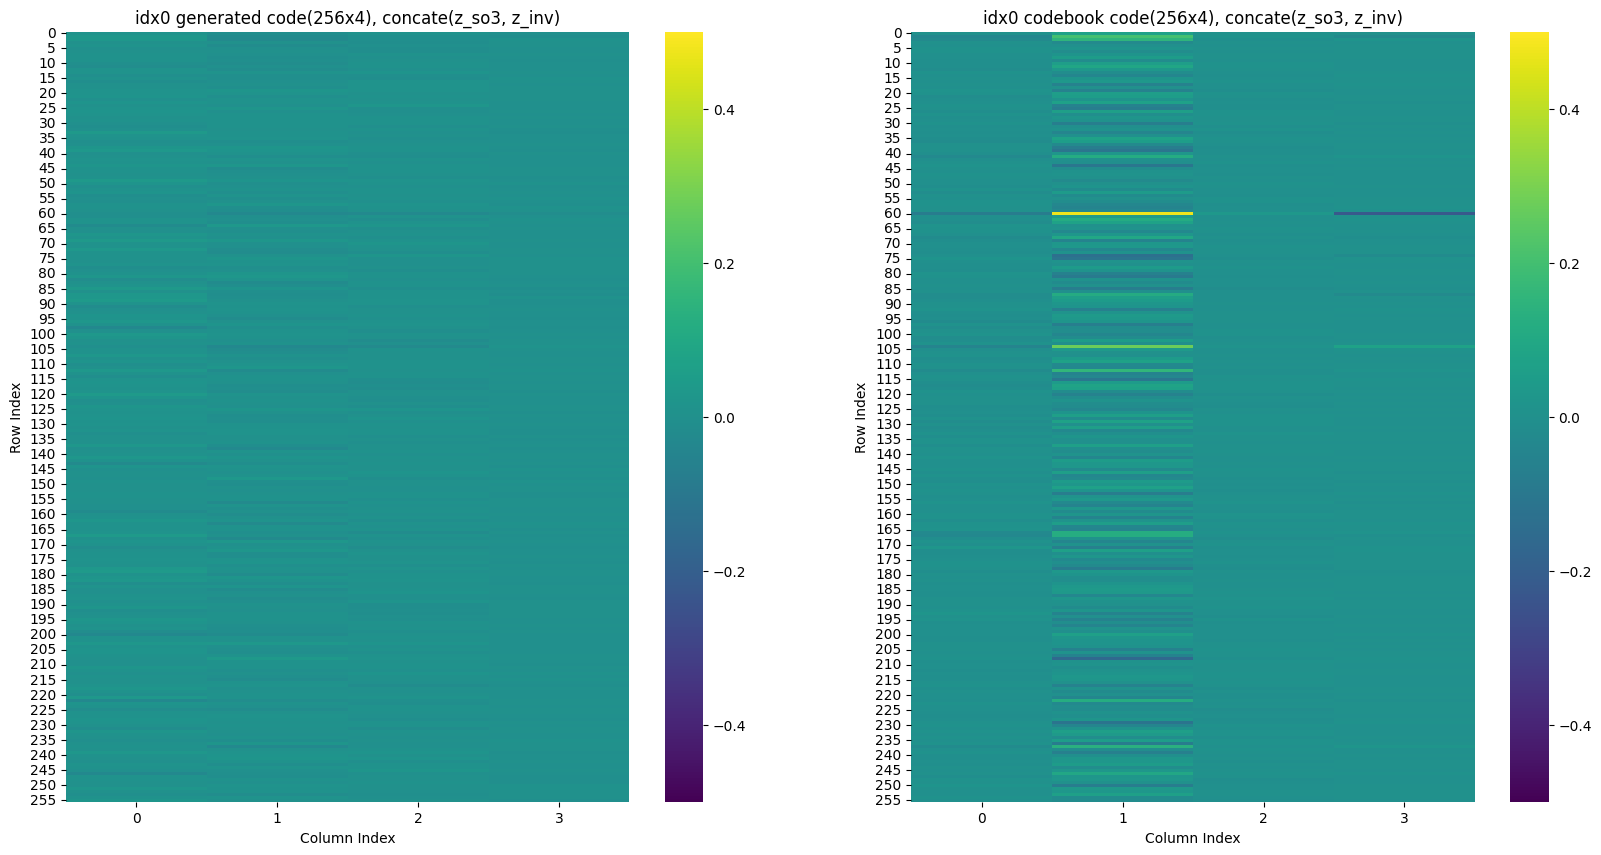

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# idx = 11
# for idx in range(10):
idx = 0
latentcode_generate = torch.concat([pred_so3_feat[idx], pred_inv_feat[idx].unsqueeze(1)], dim=1).cpu().numpy()


codebook_pred_so3_feat = codebook['z_so3'][idx]
codebook_pred_inv_feat = codebook['z_inv'][idx]
# codebook_pred_scale = codebook['scale'][idx]
# codebook_pred_scale = torch.ones_like(codebook_pred_scale) + 0.2
# codebook_pred_center = codebook['center'][idx]
# codebook_pred_center = torch.zeros_like(codebook_pred_center)

latentcode_codebook = torch.concat([codebook_pred_so3_feat, codebook_pred_inv_feat.unsqueeze(1)], dim=1).cpu().numpy()





# Visualizing both tensors using a heatmap with the same colormap
plt.figure(figsize=(20, 10))

# Heatmap for the first tensor
plt.subplot(1, 2, 1)
sns.heatmap(latentcode_generate, cmap='viridis', vmin=-0.5, vmax=0.5)
plt.title(f'idx{idx} generated code(256x4), concate(z_so3, z_inv)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

# Heatmap for the second tensor
plt.subplot(1, 2, 2)
sns.heatmap(latentcode_codebook, cmap='viridis', vmin=-0.5, vmax=0.5)
plt.title(f'idx{idx} codebook code(256x4), concate(z_so3, z_inv)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

plt.show()

## 接上, decode latent code

In [7]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np

from dataset import get_dataset
from logger import Logger
from core.models import get_model
from core import solver_dict
from init import get_cfg, setup_seed, dev_get_cfg

# preparer configuration
cfg  =dev_get_cfg()


# set random seed
setup_seed(cfg["rand_seed"])


# prepare models
ModelClass = get_model(cfg["model"]["model_name"])
model = ModelClass(cfg)
ckpt_path = "/home/ziran/se3/EFEM/weights/mugs.pt"
ckpt = torch.load(ckpt_path)


# 注意不是model.load_state_dict,
# 参见 lib_shape_prior/core/solver_v2.py, lib_shape_prior/core/models/model_base.py

model.network.load_state_dict(ckpt['model_state_dict'])
model.network.to(device)

| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-02-11:47:34 | Set GPU: 0 ...   [post_config.py:99]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-02-11:47:34 | Save configuration to local file...   [post_config.py:105]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-02-11:47:34 | DGCNN use Dynamic Graph (different from the input topology)   [vec_dgcnn_atten.py:50]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-02-11:47:34 | 2.016M params in encoder   [misc.py:16]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-02-11:47:34 | 0.790M params in decoder   [misc.py:16]
| sim3vec-mugs | user-AS-4124GS-TNR | WARNING | Dec-02-11:47:34 | Network Components != Optimizer Config   [model_base.py:31]


Please check the configuration
--------------------------------------------------------------------------------
{'dataset': {'aug_ratio': 0.7,
             'categories': ['03797390'],
             'data_root': '../data/ShapeNetV1_SDF',
             'dataset_name': 'shapenet_new2',
             'dataset_proportion': [1.0, 1.0],
             'dataset_root': 'resource/data/XXXX',
             'dep_max_use_view': 12,
             'dep_min_use_view': 4,
             'dep_total_view': 12,
             'depth_postfix': '_dep_small',
             'field_mode': 'sdf',
             'indices': {'test_index': 'None',
                         'train_index': 'None',
                         'val_index': 'None'},
             'input_mode': 'dep',
             'n_pcl': 512,
             'n_query_eval': 10000,
             'n_query_nss': 1024,
             'n_query_uni': 1024,
             'noise_std': 0.01,
             'num_workers': 8,
             'pin_mem': True,
             'ram_cache': True,
  

SIM3Recon(
  (network_dict): ModuleDict(
    (encoder): VecDGCNN_att(
      (global_conv_list): ModuleList(
        (0): VecLinearNormalizeActivate(
          (lin): VecLinear()
          (act): VecActivation(
            (act_func): LeakyReLU(negative_slope=0.2)
            (lin_dir): VecLinear()
          )
          (act_func): LeakyReLU(negative_slope=0.2)
        )
        (1): VecLinearNormalizeActivate(
          (lin): VecLinear()
          (act): VecActivation(
            (act_func): LeakyReLU(negative_slope=0.2)
            (lin_dir): VecLinear()
          )
          (act_func): LeakyReLU(negative_slope=0.2)
        )
        (2): VecLinearNormalizeActivate(
          (lin): VecLinear()
          (act): VecActivation(
            (act_func): LeakyReLU(negative_slope=0.2)
            (lin_dir): VecLinear()
          )
          (act_func): LeakyReLU(negative_slope=0.2)
        )
        (3): VecLinearNormalizeActivate(
          (lin): VecLinear()
          (act): VecActivat

In [8]:
N = 64

space_dim = [N, N, N]  # 示例为一个50x50x50的网格


di = 1
# 创建一个网格，这里我们使用np.linspace来产生线性间隔的点
x = np.linspace(-di, di, space_dim[0])
y = np.linspace(-di, di, space_dim[1])
z = np.linspace(-di, di, space_dim[2])

# 用np.meshgrid得到每个维度的点阵
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# 将这些点整理成query的形式，每行是一个点的坐标
query = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=-1)

query = torch.tensor(query,dtype=torch.float32).to(device)
query = query.repeat(pred_so3_feat.shape[0], 1, 1)
query.shape

torch.Size([1, 262144, 3])

In [9]:
embedding = {
            "z_so3": pred_so3_feat, # [B, 256, 3]
            "z_inv": pred_inv_feat, # [B, 256]
            "s": pred_scale, # [B]
            # "t": centroid.unsqueeze(1), # [B, 1, 3]
            "t": pred_center, # [B, 1, 3]
        }

sdf_hat = model.network.decode(  # SDF must have nss sampling
            query,
            None,
            embedding,
            return_sdf=True,
        )

In [10]:
sdf_grid = sdf_hat.reshape(-1, space_dim[0], space_dim[1], space_dim[2]).to("cpu").detach().numpy()
data = sdf_grid[0]

In [11]:
data.min()

0.30758864

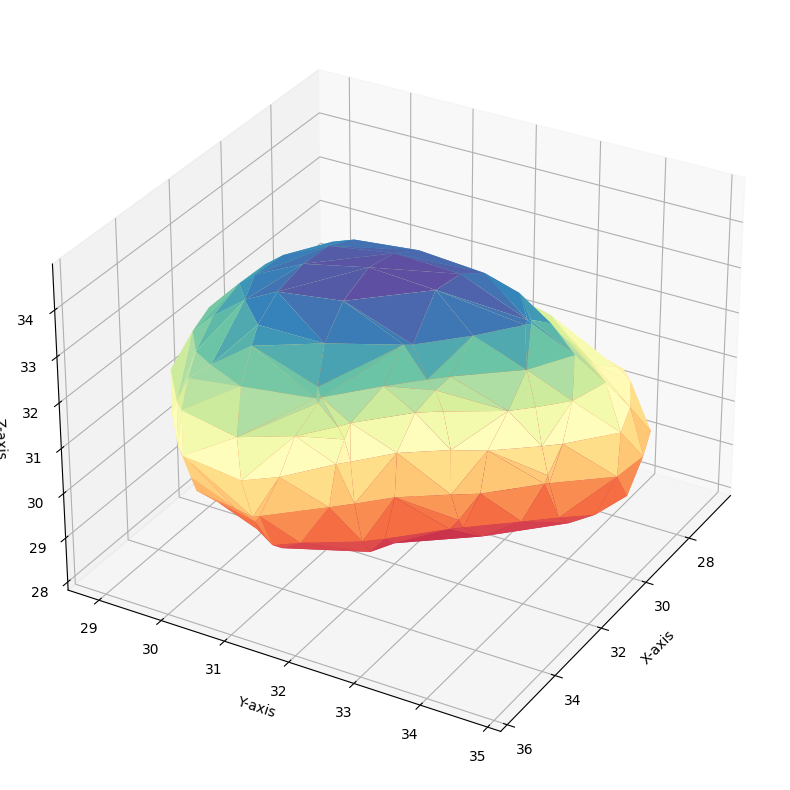

In [15]:
%matplotlib inline
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 使用 Marching Cubes 算法提取等值面
verts, faces, normals, values = measure.marching_cubes(data, level=0.5)

# 创建一个新的图形
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 绘制等值面
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                cmap='Spectral', lw=1)

# 设置图形的视角和轴标签
ax.view_init(30, 30)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.show()


## codebook 数值分布

In [17]:
codebook_path = "/home/ziran/se3/EFEM/cache/mugs.npz"

with np.load(codebook_path) as data:
    # 将 npz 文件内容转换为字典
    codebook = {key: data[key] for key in data}

del codebook['id']
for k, v in codebook.items():
    if isinstance(v, np.ndarray):
        newv = torch.from_numpy(v)
        codebook[k] = newv
    print(k, v.shape)

z_so3 (149, 256, 3)
z_inv (149, 256)
center (149, 1, 3)
scale (149,)
z_so3_proj (149, 256, 3)
z_so3_basis (149, 3, 3)
z_so3_var (149, 3)
bbox (149, 3)
bbox_c (149, 3)
pcl (149, 5000, 3)
cls (149,)


In [18]:
z_so3 = codebook['z_so3']
z_so3.mean()


tensor(0.0039)

In [23]:
z_so3_mean = codebook['z_so3'].mean(dim=[0,1])
z_so3_mean
z_so3_std = codebook['z_so3'].std(dim=[0,1])
z_so3_std

tensor([0.0322, 0.0517, 0.0097])

In [27]:
ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/model_119999.pt"
ckpt = torch.load(ckpt_path)